# リアルデータの変換

In [102]:
import sys
sys.path.append("..")

import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from glob import glob
from model import Generator
from utils.test_utils import img_transform, tensor_to_graph, net_info

from reserch_utils_HT import network_to_image, degree_hist

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# config
image_size = 100
c_dim = 4
g_repeat_num = 6
g_conv_dim = 64

for file_name in sorted(glob("../logs/*"))[:2]:
    for epoch in [100000]:
        print(file_name, epoch)
        # set generator
        model = Generator(g_conv_dim, c_dim, g_repeat_num).to(device)
        model_path = f"{file_name}/model/{epoch}-G.ckpt"
        model.load_state_dict(torch.load(model_path))
        break

../logs/poisson 100000
../logs/poisson_edge0.5 100000


In [36]:
epoch

100000

In [104]:
dataset_name = "COLLAB"
paths = glob(f"../data/TUDataset/{dataset_name}/100_graph/*.adjlist")

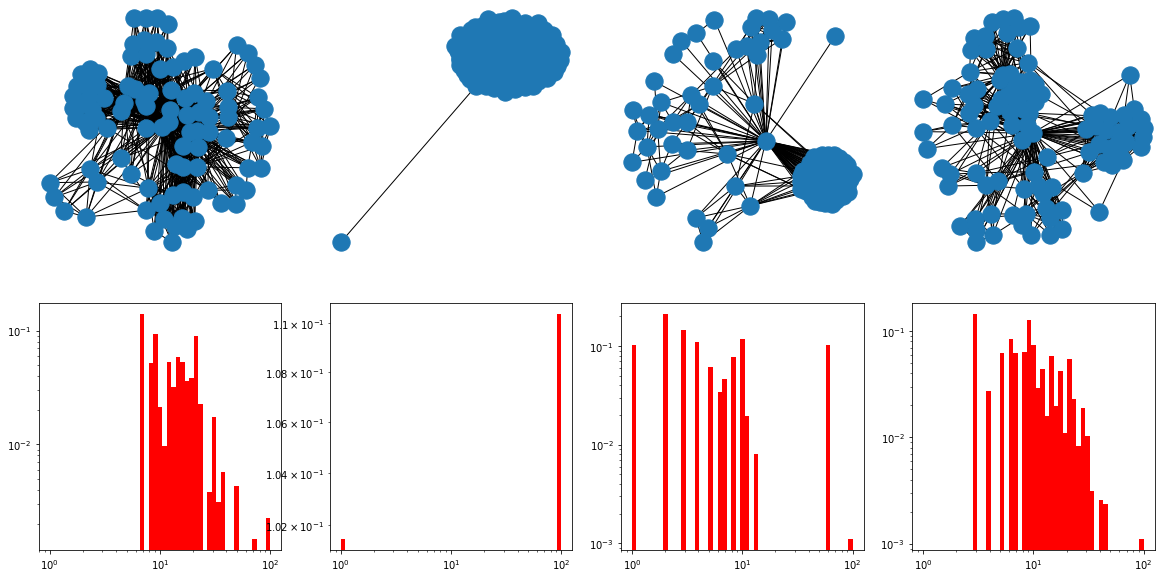

In [105]:
fig, axes = plt.subplots(2,4,figsize=(20,10))

indexs = np.random.choice(range(len(paths)), size=4, replace=False)

for i in range(4):
    G = nx.read_adjlist(paths[indexs[i]])
    nx.draw(G, ax=axes[0,i])
    degree_hist(G, ax=axes[1,i], log=True)    

In [106]:
def transform(img, model, model_label, device):
    """ image """
    # 画像前処理用
    transform = transforms.Compose(
        [
            transforms.Resize(100),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )
    # generate fake tensor
    fake_tensor = img_transform(model, img, transform, device)
    return fake_tensor

def thres_tensor(tensor, thres):
    A = (tensor + tensor.T).numpy()
    A = (A > thres).astype(int)
    return A

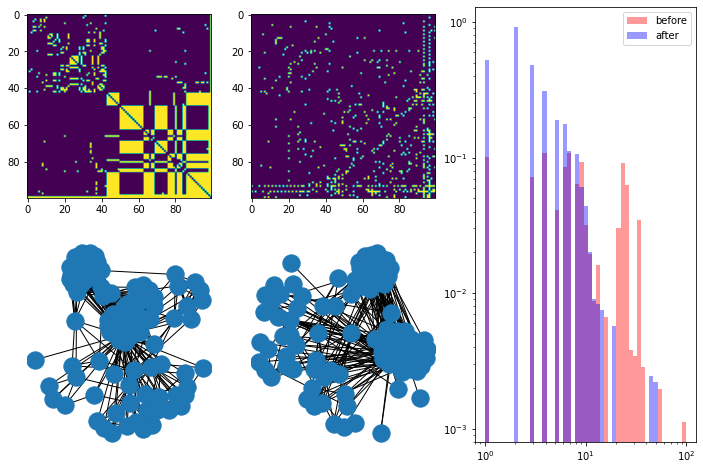

In [111]:
figure = plt.figure(figsize=(12, 8))
gs_master = GridSpec(nrows=2, ncols=3, height_ratios=[1, 1], width_ratios=[1,1,1.2])
axes=[]
for r in range(2):
    for c in range(2):
        gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[r, c])
        axes.append(figure.add_subplot(gs[0, 0]))

gs_2 = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_master[0:2, 2])
axes_2 = figure.add_subplot(gs_2[:, :])


G = nx.read_adjlist(paths[0])
mapping = {n:i for i,n in enumerate(list(G.nodes()))}
G = nx.relabel_nodes(G, mapping) # relabel

img = network_to_image(G, sort=True)

# 変換
fake_tensor = transform(img, model, 0, device)
fake_A = thres_tensor(fake_tensor[0], 1.)
fake_G = nx.from_numpy_array(fake_A[0])

# node mapping
degs = dict(G.degree())
sort_degs = sorted(degs.items(), key=lambda x: x[1])
sort_nodes = [node[0] for node in sort_degs]
fake_pos = {i:pos[num] for i,num in enumerate(sort_nodes)}

# 隣接行列
axes[0].imshow(img)
axes[1].imshow(nx.to_numpy_array(fake_G))
# グラフ
pos = nx.spring_layout(G, .1)
nx.draw(G, pos=pos, ax=axes[2])
nx.draw(fake_G, pos=fake_pos, ax=axes[3])
# hist
degree_hist(G, ax=axes_2, color='r', alpha=.4,log=True,label="before")
degree_hist(fake_G, ax=axes_2, color='b', alpha=.4,log=True, label="after")
axes_2.legend()

# twitter social

In [192]:
from PIL import Image

def network_to_image(G, sort=False, shuffle=False, seed=None, t=False):
    def _sort_by_degree(A, G):
        # 隣接行列を次数の昇順に並び替える
        # 次数の辞書を取得
        degs = dict(G.degree())
        # value(次数)で並び替え
        sort_degs = sorted(degs.items(), key=lambda x: x[1])
        sort_nodes = [node[0] for node in sort_degs]
        # 行, 列並び替え
        A = A[:, sort_nodes]
        A = A[sort_nodes, :]
        return A

    # 隣接行列の作成
    A = nx.to_numpy_array(G)
    # shuffle
    if shuffle:
        A = _shuffle(A, seed)
    # sort
    if sort:
        A = _sort_by_degree(A, G)
    if t:
        A = A + A.T
    # array to image
    img = Image.fromarray(A * 255).convert("L")
    return img

def make_graph(graph_index,graph_indicator,edges_list):
    # node id list
    node_ids = np.where(graph_indicator == graph_index)[0]
    # edge抽出
    edges = []
    for e in edges_list:
        if e[0] in node_ids and e[1] in node_ids:
            edges.append(e)
    
    # make graph
    G = nx.DiGraph()
    G.add_nodes_from(node_ids)
    G.add_edges_from(edges)
    
    print(f"index: {graph_index}, node: {nx.number_of_nodes(G)}, edges: {nx.number_of_edges(G)}")
    return G

In [134]:
# set Generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoch = 100000
model = Generator(g_conv_dim, c_dim, g_repeat_num).to(device)
model_path = f"../logs/poisson/model/{epoch}-G.ckpt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [118]:
graph_indicator = np.loadtxt("../data/TUDataset/facebook_ct1/facebook_ct1_graph_indicator.txt").astype(int)
edges_list = np.loadtxt("../data/TUDataset/facebook_ct1/facebook_ct1_A.txt", delimiter=',').astype(int)
graph_label = np.loadtxt("../data/TUDataset/facebook_ct1/facebook_ct1_graph_labels.txt").astype(int)

In [123]:
# 100 node 探し
size100_index = []
for i in range(1, len(graph_label)+1):
    graph_size = len(np.where(graph_indicator == i)[0])
    if graph_size == 100:
        size100_index.append(i)

index: 1, node: 100, edges: 208


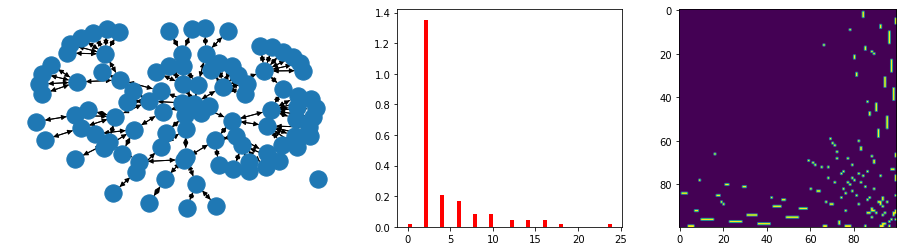

In [124]:
graph_index = size100_index[0]
G = make_graph(graph_index,graph_indicator,edges_list)

fig, axes = plt.subplots(1,3,figsize=(16,4), gridspec_kw={'width_ratios': [1.5,1,1]})
# pos = nx.spring_layout(G, .15)
pos = nx.nx_pydot.graphviz_layout(G)
# pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos,ax=axes[0])
degree_hist(G, ax=axes[1])

mapping = {n:i for i,n in enumerate(list(G.nodes))}
new_G = nx.relabel_nodes(G, mapping)
img = network_to_image(new_G,sort=True)
axes[2].imshow(img)

plt.show()

index: 43, node: 100, edges: 209


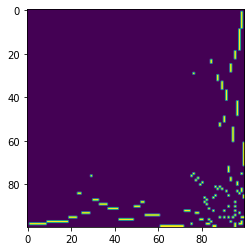

In [166]:
graph_index = size100_index[12]
G = make_graph(graph_index,graph_indicator,edges_list)

mapping = {n:i for i,n in enumerate(list(G.nodes))}
G = nx.relabel_nodes(G, mapping)

img = network_to_image(G, sort=True)
plt.imshow(img)

In [169]:
# set Generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoch = 100000
model = Generator(g_conv_dim, c_dim, g_repeat_num).to(device)
model_path = f"../logs/subset1/model/{epoch}-G.ckpt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

index: 43, node: 100, edges: 209


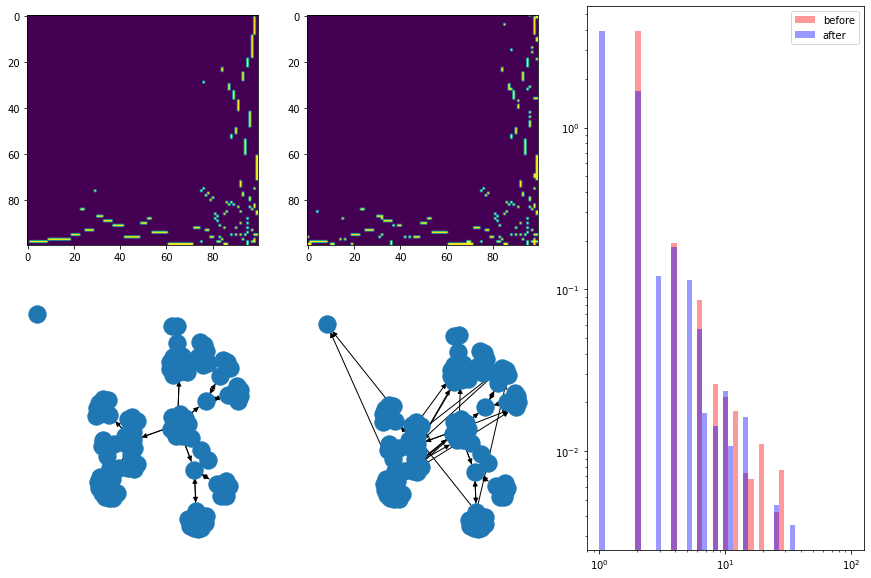

In [193]:
figure = plt.figure(figsize=(15, 10))
gs_master = GridSpec(nrows=2, ncols=3, height_ratios=[1, 1], width_ratios=[1,1,1.2])
axes=[]
for r in range(2):
    for c in range(2):
        gs = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[r, c])
        axes.append(figure.add_subplot(gs[0, 0]))

gs_2 = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_master[0:2, 2])
axes_2 = figure.add_subplot(gs_2[:, :])


graph_index = size100_index[11]
G = make_graph(graph_index,graph_indicator,edges_list)

mapping = {n:i for i,n in enumerate(list(G.nodes))}
G = nx.relabel_nodes(G, mapping)

img = network_to_image(G, sort=True)

# 変換
fake_tensor = transform(img, model, 0, device)
fake_A = thres_tensor(fake_tensor[0], 1.)
fake_G = nx.from_numpy_array(fake_A[0], create_using=nx.DiGraph())

# node mapping
pos = nx.spring_layout(G, .1)

degs = dict(G.degree())
sort_degs = sorted(degs.items(), key=lambda x: x[1])
sort_nodes = [node[0] for node in sort_degs]
fake_pos = {i:pos[num] for i,num in enumerate(sort_nodes)}

re_mapping = {i:num for i,num in enumerate(sort_nodes)}
fake_G = nx.relabel_nodes(fake_G, re_mapping)

# 隣接行列
axes[0].imshow(img)

fake_A = nx.to_numpy_array(fake_G)
fake_A = (fake_A + fake_A.T) != 0
axes[1].imshow(fake_A)
# グラフ
nx.draw(G, pos=pos, ax=axes[2])
nx.draw(fake_G, pos=pos, ax=axes[3])
# hist
degree_hist(G, ax=axes_2, color='r', alpha=.4,log=True,label="before")
degree_hist(fake_G, ax=axes_2, color='b', alpha=.4,log=True, label="after")
axes_2.legend()

In [140]:
from reserch_utils_HT import draw_origin

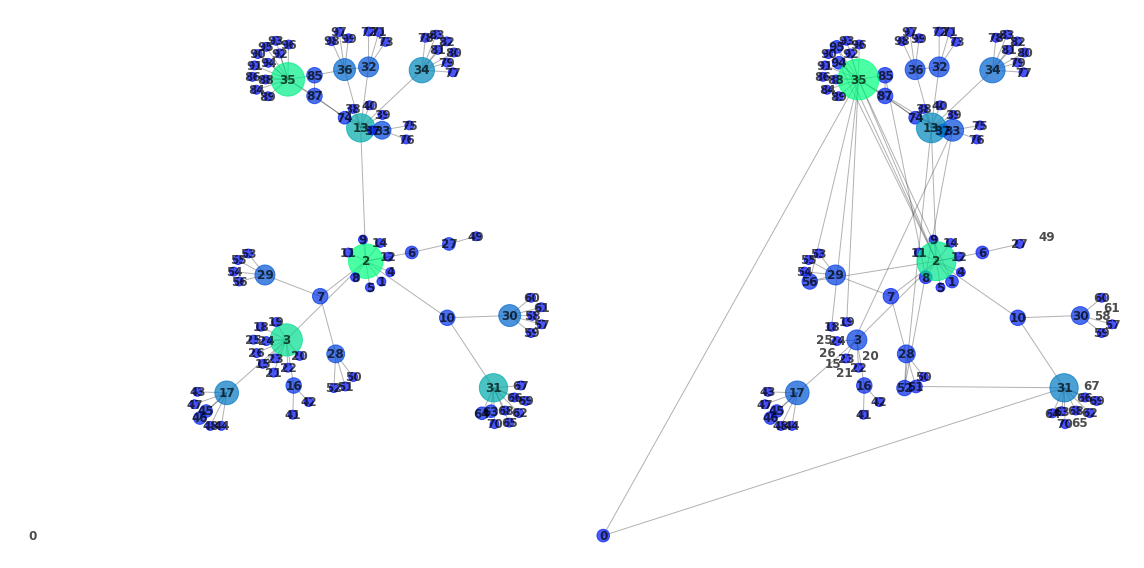

In [171]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

new_1 = nx.Graph(G)
draw_origin(new_1, pos=pos, ax=axes[0],cbar=False)
new_2 = nx.Graph(fake_G)
draw_origin(new_2, pos=pos, ax=axes[1],cbar=False)
plt.tight_layout()

In [ ]:
print()

In [191]:
print(f"Num edge : before={nx.number_of_edges(new_1)}, after={nx.number_of_edges(new_2)}")

new1_e = set()
for e in new_1.edges():
    new1_e.add(tuple(sorted(e)))

new2_e = set()
for e in new_2.edges():
    new2_e.add(tuple(sorted(e)))

print(f"{len(new1_e&new2_e)}")

Num edge : before=105, after=106
90
